In [29]:
import os
import openreview
import re
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
client = openreview.Client(
    baseurl="https://api.openreview.net", username=os.getenv('OPENREIVEW_USERNAME'), password=os.getenv('OPENREVIEW_PASSWORD')
)

In [10]:
def get_venue_ids(conference: str):
    """get conference venue id 

    Args:
        conference (str): conference name string. E.g. NeurIPS

    Returns:
        dict: {year: [list of venue ids for the year]}
    """
    venues = client.get_group(id='venues').members
    out = {}
    for v in venues:
        name_list = v.split('/')
        name_search_result = [re.findall(f"^{conference}\.?.*", element) for element in name_list]
        if any(name_search_result):
            year_search_result = [re.findall(r'\d+', element) for element in name_list if len(re.findall(r'\d{4}', element)) == 1]
            if not year_search_result:
                continue
            assert len(year_search_result) == 1, f"{name_list} -> {year_search_result} | More than one numeric year found in venue name. e.g.: **/2022/**/2024"
            assert len(year_search_result[0]) == 1, f"{name_list} -> {year_search_result} | More than one numeric year found in venue name. e.g.: **/2022paper2024/**"

            year = year_search_result[0][0]
            if year not in out:
                out[year] = []
            out[year].append(v)
    return out


In [11]:
venue_ids = get_venue_ids("NeurIPS")
venue_ids

{'2019': ['NeurIPS.cc/2019/Workshop/DC_S1',
  'NeurIPS.cc/2019/Workshop/DC_S2',
  'NeurIPS.cc/2019/Workshop/Deep_Inverse',
  'NeurIPS.cc/2019/Workshop/Document_Intelligence',
  'NeurIPS.cc/2019/Workshop/Neuro_AI',
  'NeurIPS.cc/2019/Workshop/Program_Transformations',
  'NeurIPS.cc/2019/Workshop/Retrospectives',
  'NeurIPS.cc/2019/Workshop/SVRHM',
  'NeurIPS.cc/2019/Workshop/Sets_Parts'],
 '2020': ['NeurIPS.cc/2020/Conference',
  'NeurIPS.cc/2020/Workshop/CAP',
  'NeurIPS.cc/2020/Workshop/DL-IG',
  'NeurIPS.cc/2020/Workshop/Deep_Inverse',
  'NeurIPS.cc/2020/Workshop/HAMLETS',
  'NeurIPS.cc/2020/Workshop/ICBINB',
  'NeurIPS.cc/2020/Workshop/LMCA',
  'NeurIPS.cc/2020/Workshop/SVRHM',
  'NeurIPS.cc/2020/Workshop/TDA_and_Beyond'],
 '2021': ['NeurIPS.cc/2021/Conference',
  'NeurIPS.cc/2021/Track/Datasets_and_Benchmarks/Round1',
  'NeurIPS.cc/2021/Track/Datasets_and_Benchmarks/Round2',
  'NeurIPS.cc/2021/Workshop/AI4Science',
  'NeurIPS.cc/2021/Workshop/AIPLANS',
  'NeurIPS.cc/2021/Workshop/B

In [12]:
# get submissions info

submissions = []
for year in venue_ids.keys():
    for conferece_id in venue_ids[year]:
        submissions += client.get_all_notes(content={'venueid': conferece_id})



Getting V1 Notes: 100%|█████████▉| 2821/2824 [00:01<00:00, 1410.90it/s]


In [20]:
for i, note in enumerate(submissions):
    print("Title:", note.content['title'])
    print("Keywords:", note.content['keywords'])
    print(f"Abstract:\n\t{note.content['abstract']}")
    print("Authors")
    for authorid in note.content['authorids']:
        try:
            profile = client.get_profile(email_or_id=authorid)
            latest_name = [ele['fullname'] for ele in profile.content['names']][0]
            institutions = [ele['institution']['name'] for ele in profile.content['history'] if ele['end'] is None]
        except Exception:
            latest_name = "NA"
            institutions = []
        print(f"\t{latest_name} ({authorid}): {institutions}")

    # get time for note and format to string
    print(f"Date: {datetime.fromtimestamp(note.tcdate / 1000).strftime('%Y-%m-%d')}")
    print("\n")
    print("=" * 150)
    print("\n")
    if i == 1:
        break

Title: Low Shot Learning with Untrained Neural Networks for Imaging Inverse Problems
Keywords: ['Inverse problems', 'compressed sensing', 'low shot learning', 'image priors', 'untrained neural networks', 'generative priors']
Abstract:
	Employing deep neural networks as natural image priors to solve inverse problems either requires large amounts of data to sufficiently train expressive generative models or can succeed with no data via untrained neural networks. However, very few works have considered how to interpolate between these no- to high-data regimes. In particular, how can one use the availability of a small amount of data (even 5-25 examples) to one's advantage in solving these inverse problems and can a system's performance increase as the amount of data increases as well? In this work, we consider solving linear inverse problems when given a small number of examples of images that are drawn from the same distribution as the image of interest. Comparing to untrained neural net

In [24]:
# get author profile and affiliation

row_list = []
retrieved_authors = {}

for note in tqdm(submissions[:100]):
    try:
        for authorid in note.content['authorids']:
            if authorid not in retrieved_authors:
                retrieved_authors[authorid] = {}
                try:
                    profile = client.get_profile(email_or_id=authorid)
                    retrieved_authors[authorid]['latest_name'] = [ele['fullname'] for ele in profile.content['names']][0]
                    retrieved_authors[authorid]['institutions'] = [ele['institution']['name'] for ele in profile.content['history'] if ele['end'] is None]
                except Exception:
                    retrieved_authors[authorid]['latest_name'] = "NA"
                    retrieved_authors[authorid]['institutions'] = []
            
            row_list.append({
                'id': note.id, 
                'date': datetime.fromtimestamp(note.tcdate / 1000),
                'title': note.content['title'], 
                'abstract': note.content['abstract'],
                'company': retrieved_authors[authorid]['institutions'], 
                'author': retrieved_authors[authorid]['latest_name']
            })
    except Exception:
        continue

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [31]:
df = pd.DataFrame(row_list).explode('company').dropna().drop_duplicates()
company_paper_df = df[['id', 'date', 'title', 'abstract', 'company']].drop_duplicates().reset_index(drop=True)

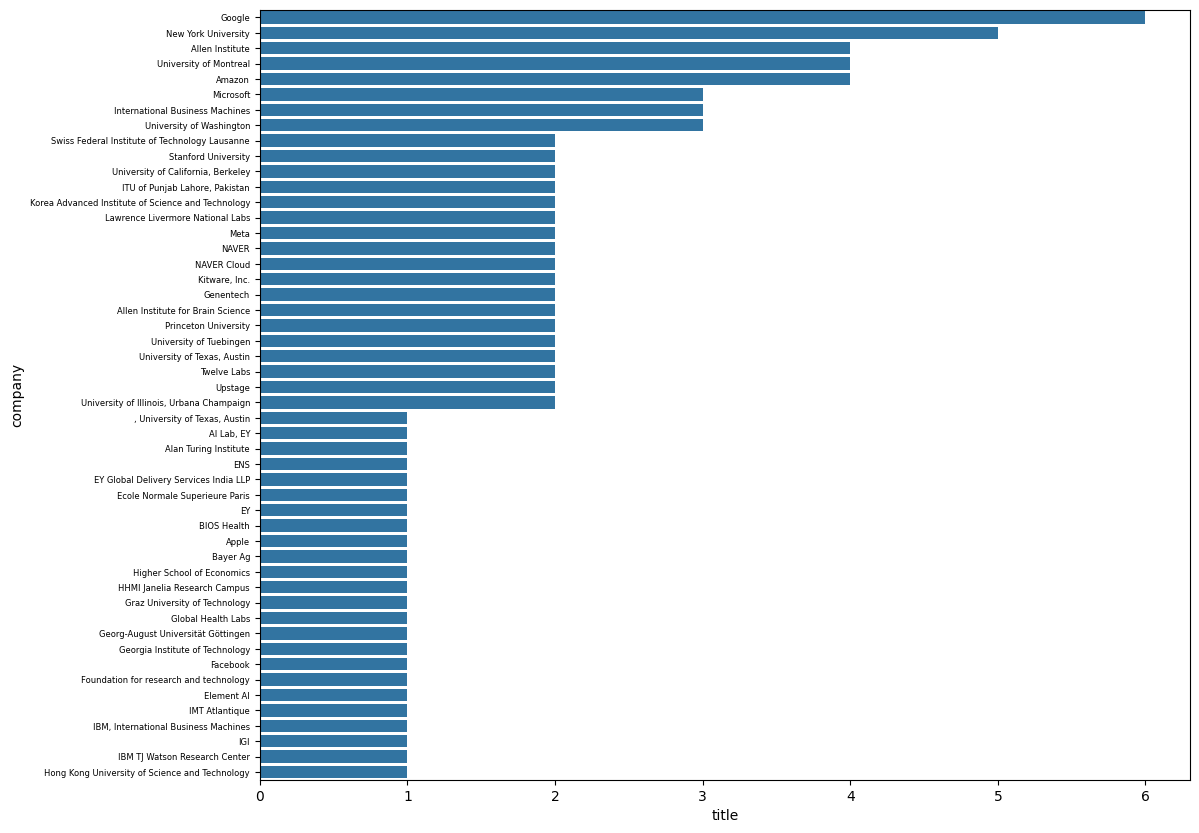

In [32]:
company_paper_histogram_df = company_paper_df.groupby('company')[['title']].count().reset_index().sort_values('title', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(12,10))
sns.barplot(data=company_paper_histogram_df.head(50), x='title', y='company', ax=ax)
ax.tick_params(axis='y', labelsize=6)
plt.show()